# Train 1-layer feed-forward net on linear func of symbolic time-series

## Make test dataset

Input: markov-chain generated sequence of discrete symbols 0, 1, 2
Output: input sequence filtered by symbol-specific differentiating filters, optionally passed through a sigmoidal nonlinearity and subjected to additive output noise

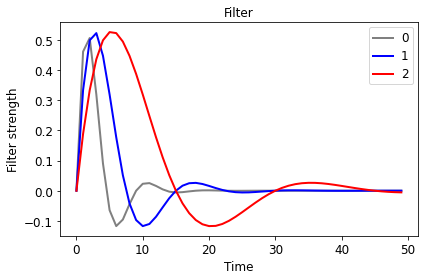

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal

from disp import set_font_size


T = 5000

TR_MAT = np.array([
    [.5, .2, .3],  # from 0
    [.2, .6, .2],  # from 1
    [.1, .2, .7],  # from 2
])

T_H = 50
hs = [np.exp(-np.arange(T_H, dtype=float)/tau) * np.sin(2*np.pi*np.arange(T_H)/(3*tau)) for tau in [3, 5, 10]]

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
for h, c in zip(hs, ['gray', 'b', 'r']):
    ax.plot(np.arange(T_H), h, lw=2, c=c)
ax.set_xlabel('Time')
ax.set_ylabel('Filter strength')
ax.set_title('Filter')
ax.legend(['0', '1', '2'])

set_font_size(ax, 12)

NOISE = 1

def sgm(y):
    return 1/(1 + np.exp(-y))

Text(0, 0.5, 'z')

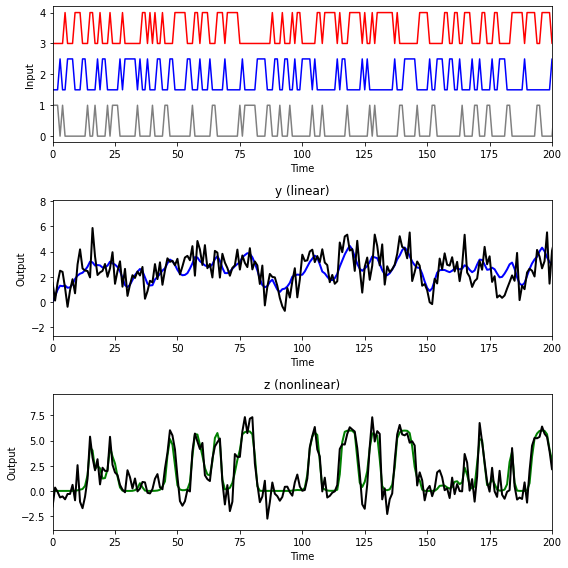

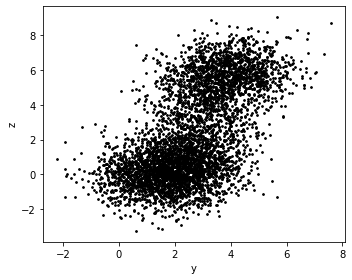

In [2]:
N_TR = 50

xs = []

for ctr in range(N_TR):
    x = -1 * np.ones(T, dtype=int)
    x[0] = 0
    for ct in range(1, T):
        x[ct] = np.random.choice(np.arange(3), p=TR_MAT[x[ct-1]])
    
    xs.append(x)
    
ys = []
ys_clean = []
zs = []
zs_clean = []

for x in xs:
    y = signal.fftconvolve((x == 0).astype(float), hs[0], mode='full')[:len(x)] \
        + signal.fftconvolve((x == 1).astype(float), hs[1], mode='full')[:len(x)] \
        + signal.fftconvolve((x == 2).astype(float), hs[2], mode='full')[:len(x)]
    
    ys_clean.append(y)
    ys.append(y + NOISE*np.random.randn(len(x)))
    
    z = 6*sgm(5*(y-3))
    
    zs_clean.append(z)
    zs.append(z + NOISE*np.random.randn(len(x)))
    
fig, axs = plt.subplots(3, 1, figsize=(8, 8), tight_layout=True)
axs[0].plot(xs[0] == 0, c='gray')
axs[0].plot((xs[0] == 1) + 1.5, c='b')
axs[0].plot((xs[0] == 2) + 3, c='r')
axs[0].set_ylabel('Input')

axs[1].plot(ys_clean[0], lw=2, c='b')
axs[1].plot(ys[0], lw=2, c='k')
axs[1].set_ylabel('Output')
axs[1].set_title('y (linear)')

axs[2].plot(zs_clean[0], lw=2, c='g')
axs[2].plot(zs[0], lw=2, c='k')
axs[2].set_ylabel('Output')
axs[2].set_title('z (nonlinear)')

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_xlim(0, 200)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(ys[0], zs[0], c='k', s=3)
ax.set_xlabel('y')
ax.set_ylabel('z')

Text(0, 0.5, 'z')

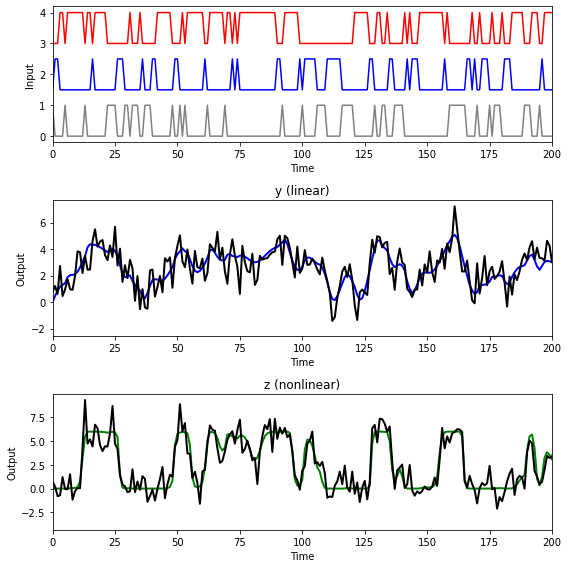

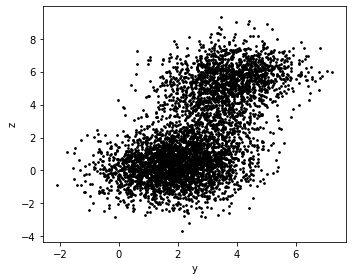

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8), tight_layout=True)
axs[0].plot(xs[1] == 0, c='gray')
axs[0].plot((xs[1] == 1) + 1.5, c='b')
axs[0].plot((xs[1] == 2) + 3, c='r')
axs[0].set_ylabel('Input')

axs[1].plot(ys_clean[1], lw=2, c='b')
axs[1].plot(ys[1], lw=2, c='k')
axs[1].set_ylabel('Output')
axs[1].set_title('y (linear)')

axs[2].plot(zs_clean[1], lw=2, c='g')
axs[2].plot(zs[1], lw=2, c='k')
axs[2].set_ylabel('Output')
axs[2].set_title('z (nonlinear)')

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_xlim(0, 200)
    
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)
ax.scatter(ys[1], zs[1], c='k', s=3)
ax.set_xlabel('y')
ax.set_ylabel('z')

In [4]:
# make dataframe to save data
tr_ids = [np.repeat(ctr, len(y)) for ctr, y in enumerate(ys)]

df = pd.DataFrame(
    columns=['ID', 'Q', 'S', 'P', 'Y_CLEAN', 'Y', 'Z_CLEAN', 'Z'],
    data={
        'ID': np.concatenate(tr_ids),
        'Q': np.concatenate([x==0 for x in xs]),
        'S': np.concatenate([x==1 for x in xs]),
        'P': np.concatenate([x==2 for x in xs]),
        'Y_CLEAN': np.concatenate(ys_clean),
        'Y': np.concatenate(ys),
        'Z_CLEAN': np.concatenate(zs_clean),
        'Z': np.concatenate(zs),
    })

df.to_csv('data.csv', index=False)

In [5]:
# baseline R2s
from scipy import stats
print('R^2 between best y predicted and y:')
r2_y = stats.linregress(df['Y_CLEAN'], df['Y'])[2]**2
print(r2_y)

print('R^2 between best z predicted and z:')
r2_z = stats.linregress(df['Z_CLEAN'], df['Z'])[2]**2
print(r2_z)

R^2 between best y predicted and y:
0.5153145103669432
R^2 between best z predicted and z:
0.8597729118348357


In [6]:
df[df['ID'] == 0]

,ID,Q,S,P,Y_CLEAN,Y,Z_CLEAN,Z
0,0,True,False,False,3.996803e-16,1.505499,0.000002,-1.535259
1,0,True,False,False,4.605774e-01,0.106129,0.000018,0.334032
2,0,True,False,False,9.661946e-01,1.505828,0.000230,-0.087713
3,0,False,True,False,1.284788e+00,2.477920,0.001131,-0.647968
4,0,True,False,False,1.247373e+00,2.382209,0.000938,-0.544635
...,...,...,...,...,...,...,...,...
4995,0,False,False,True,9.003024e-01,1.334199,0.000165,0.296855
4996,0,False,False,True,1.056425e+00,0.557577,0.000361,-0.120521
4997,0,False,False,True,1.411622e+00,0.901449,0.002132,0.786494
4998,0,False,False,True,1.882538e+00,2.706003,0.022387,-1.536373


In [7]:
df[df['ID'] == 1]

,ID,Q,S,P,Y_CLEAN,Y,Z_CLEAN,Z
5000,1,True,False,False,-7.993606e-16,0.746448,0.000002,0.704902
5001,1,False,True,False,4.605774e-01,1.210736,0.000018,0.214438
5002,1,False,True,False,8.386250e-01,0.608658,0.000122,-0.796083
5003,1,False,False,True,1.149746e+00,2.719820,0.000576,-0.706397
5004,1,False,False,True,1.298378e+00,0.452132,0.001211,1.212647
...,...,...,...,...,...,...,...,...
9995,1,False,True,False,1.966138e+00,1.381074,0.033938,-1.187639
9996,1,False,False,True,2.063781e+00,1.603390,0.055102,-2.324017
9997,1,True,False,False,2.049095e+00,1.390646,0.051235,-0.676717
9998,1,True,False,False,2.296081e+00,2.524286,0.172559,-0.220217


# Fit sklearn linear regression and pytorch neural net

In [8]:
from sklearn import linear_model
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [9]:
class SymDataset(Dataset):
    def __init__(self, data_file, lag=50, rtr=(0, 50), transform=None):
        df = pd.read_csv(data_file)
        xs = []
        ys = []
        ys_clean = []
        zs = []
        zs_clean = []
        
        for ctr in range(*rtr):
            df_tr = df[df['ID'] == ctr]
            for t in range(lag, len(df_tr)+1):
                xs.append(np.concatenate([
                    df_tr['Q'].iloc[t-lag:t], df_tr['S'].iloc[t-lag:t], df_tr['P'].iloc[t-lag:t]]))
                
                ys.append(df_tr['Y'].iloc[t-1])
                ys_clean.append(df_tr['Y_CLEAN'].iloc[t-1])
                zs.append(df_tr['Z'].iloc[t-1])
                zs_clean.append(df_tr['Z_CLEAN'].iloc[t-1])
            
        self.xs = np.array(xs)
        self.ys = np.array(ys)
        self.ys_clean = np.array(ys_clean)
        self.zs = np.array(zs)
        self.zs_clean = np.array(zs_clean)
        
        self.lag = lag
        self.transform = transform
        
    def __len__(self):
        return len(self.ys)
    
    def __getitem__(self, idx):
        if self.transform:
            x = self.transform(self.xs[idx])
        else:
            x = self.xs[idx]
            
        trg = np.array([self.ys_clean[idx]])
        
        return x, trg

In [10]:
# make datasets
sym_data_train = SymDataset('data.csv', rtr=(0, 20), transform=None)  # note: ToTensor does not mess up passing to sklearn
sym_data_test = SymDataset('data.csv', rtr=(20, 25), transform=None)  # note: ToTensor does not mess up passing to sklearn

1.0
1.0
0.5135585687745188
0.5167904526414684
0.7015243734761101
0.7003940322399904


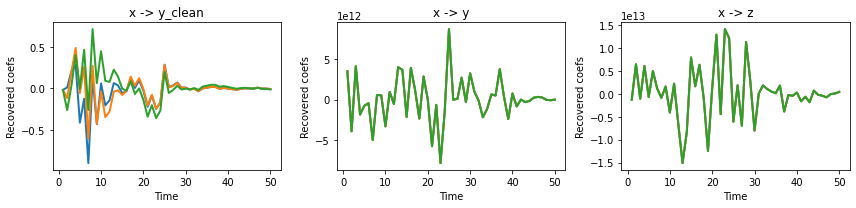

In [11]:
# fit using scikit-learn LinearRegression
fig, axs = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)

mdl = linear_model.LinearRegression().fit(sym_data_train.xs, sym_data_train.ys_clean)
print(mdl.score(sym_data_train.xs, sym_data_train.ys_clean))
print(mdl.score(sym_data_test.xs, sym_data_test.ys_clean))
axs[0].plot(np.arange(50, 0, -1), mdl.coef_.reshape(3, 50).T, lw=2)
axs[0].set_title('x -> y_clean')

mdl = linear_model.LinearRegression().fit(sym_data_train.xs, sym_data_train.ys)
print(mdl.score(sym_data_train.xs, sym_data_train.ys))
print(mdl.score(sym_data_test.xs, sym_data_test.ys))
axs[1].plot(np.arange(50, 0, -1), mdl.coef_.reshape(3, 50).T, lw=2)
axs[1].set_title('x -> y')

mdl = linear_model.LinearRegression().fit(sym_data_train.xs, sym_data_train.zs)
print(mdl.score(sym_data_train.xs, sym_data_train.zs))
print(mdl.score(sym_data_test.xs, sym_data_test.zs))
axs[2].plot(np.arange(50, 0, -1), mdl.coef_.reshape(3, 50).T, lw=2)
axs[2].set_title('x -> z')

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Recovered coefs')

In [12]:
# make data loaders
train_dataloader = DataLoader(sym_data_train, batch_size=64, shuffle=True)
test_dataloader = DataLoader(sym_data_test, batch_size=64, shuffle=True)

In [13]:
for x, y in train_dataloader:
    print('Shape of x:', x.shape)
    print('Shape of y:', y.shape)
    break

Shape of x: torch.Size([64, 150])
Shape of y: torch.Size([64, 1])


In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(150, 1),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_stack(x)
        return pred
    
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=150, out_features=1, bias=True)
  )
)


In [15]:
loss_fn = nn.MSELoss()  # https://pytorch.org/docs/stable/nn.html#loss-functions for all loss funcs
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        # compute prediction error
        pred = model(x.float())
        loss = loss_fn(pred, y.float())
        
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')
            

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x.float())
            test_loss += loss_fn(pred, y.float()).item()
            
        test_loss /= num_batches
        print(f'Avg loss: {test_loss:>8f}\n')

In [17]:
n_epoch = 15
for cepoch in range(n_epoch):
    print(f'Epoch {cepoch+1}\n---------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
---------------
loss: 8.365897 [    0/99020]
loss: 0.638265 [ 6400/99020]
loss: 0.640857 [12800/99020]
loss: 0.505710 [19200/99020]
loss: 0.400970 [25600/99020]
loss: 0.263489 [32000/99020]
loss: 0.151765 [38400/99020]
loss: 0.162232 [44800/99020]
loss: 0.142844 [51200/99020]
loss: 0.064999 [57600/99020]
loss: 0.081291 [64000/99020]
loss: 0.056393 [70400/99020]
loss: 0.044575 [76800/99020]
loss: 0.048528 [83200/99020]
loss: 0.034468 [89600/99020]
loss: 0.025064 [96000/99020]
Avg loss: 0.027075

Epoch 2
---------------
loss: 0.033566 [    0/99020]
loss: 0.020229 [ 6400/99020]
loss: 0.017547 [12800/99020]
loss: 0.014582 [19200/99020]
loss: 0.018100 [25600/99020]
loss: 0.011426 [32000/99020]
loss: 0.012128 [38400/99020]
loss: 0.015139 [44800/99020]
loss: 0.006724 [51200/99020]
loss: 0.009344 [57600/99020]
loss: 0.006822 [64000/99020]
loss: 0.006895 [70400/99020]
loss: 0.007351 [76800/99020]
loss: 0.005612 [83200/99020]
loss: 0.005958 [89600/99020]
loss: 0.004025 [96000/99020]
Avg 